# Load modules

In [1]:
# Plotting modules
%matplotlib qt

from ipywidgets import interactive, fixed, Layout
import ipywidgets as widgets

import matplotlib.pyplot as plt

#* Set font style. Check the default matplotlibrc file to see all the available parameters
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.titleweight'] = 'bold'

plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 10

plt.rcParams['legend.fontsize'] = 15

from mpl_toolkits.axes_grid1 import make_axes_locatable

from IPython.display import display

# System modules
import os
import time
import pickle
import importlib
from python_settings import M_drive_path_VCSEL
from pathlib import Path

#* CUSTOM MODULES
import plots
importlib.reload(plots)
import plots as plots

import mathutils
importlib.reload(mathutils)
import mathutils as mathutils

import GPU_codebase
importlib.reload(GPU_codebase)
import GPU_codebase as GPU_codebase

import modes
importlib.reload(modes)
import modes as modes

#* COMPUTING MODULES
import numpy as np
import cupy as cp
from itertools import product
from scipy.linalg import schur, eigvals

# Used Python Kernel
from platform import python_version
print(f'You are running Python {python_version()}')


You are running Python 3.8.8


# Define often used math utils

In [2]:
def gellmann(j, k, d):
    if j > k:
        gjkd = np.zeros((d, d), dtype=np.complex128)
        gjkd[j - 1][k - 1] = 1
        gjkd[k - 1][j - 1] = 1
    elif k > j:
        gjkd = np.zeros((d, d), dtype=np.complex128)
        gjkd[j - 1][k - 1] = -1.j
        gjkd[k - 1][j - 1] = 1.j
    elif j == k and j < d:
        gjkd = np.sqrt(2/(j*(j + 1)))*np.diag([1 + 0.j if n <= j
                                                else (-j + 0.j if n == (j + 1)
                                                else 0 + 0.j)
                                                for n in range(1, d + 1)])
    else:
        gjkd = np.diag([1 + 0.j for n in range(1, d + 1)])

    return gjkd

def get_basis(d, order = ("normal", "reverse")[0], exclude_identity_from_basis = True):
    
    gjkd_reverse_order = [gellmann(j, k, d) for j, k in product(range(1, d + 1), repeat=2)]        
    gjkd_normal_order = gjkd_reverse_order[::-1]
    
    class basis_obj:
        pass
    
    gm_basis = basis_obj()
    
    if order == "normal":
        if exclude_identity_from_basis:
            gm_basis.basis = gjkd_normal_order[1:]
            gm_basis.identity_matrix = gjkd_normal_order[0]
            gm_basis.dim = d**2 -1
        else:
            gm_basis.basis = gjkd_normal_order
            gm_basis.dim = d**2    
        
    elif order == "reverse":
        if exclude_identity_from_basis:
            gm_basis.basis = gjkd_reverse_order[:-2]
            gm_basis.identity_matrix = gjkd_normal_order[-1]
            gm_basis.dim = d**2 -1
        else:
            gm_basis.basis = gjkd_reverse_order
            gm_basis.dim = d**2   
        
    return gm_basis

def get_gm_eig_vecs_and_vals(gm_basis):
    gm_eig_vals_vectors = []

    for gm_idx in range(gm_basis.dim):
        T, Z = schur(gm_basis.basis[gm_idx])
        _buffer = []
        for vec_idx in range(N):
            _buffer.append({"eigenvalue":eigvals(T)[vec_idx].real,"eigenvector": Z[:,vec_idx]})
        gm_eig_vals_vectors.append(_buffer)       
    
    return gm_eig_vals_vectors

def get_unique_vecs_and_vals(gm_basis):
    gm_eigvecs = []
    gm_eigvals = []

    for gm_idx in range(gm_basis.dim):
        T, Z = schur(gm_basis.basis[gm_idx])
        for vec_idx in range(N):
            if eigvals(T)[vec_idx].real != 0:
                gm_eigvecs.append(Z[:,vec_idx])
                gm_eigvals.append(eigvals(T)[vec_idx].real)
    gm_eigvecs = np.array(gm_eigvecs)
    gm_eigvals = np.array(gm_eigvals)
    
    unique_gm_eigvecs, unique_idxs = np.unique(gm_eigvecs, axis = 0, return_index = True)

    unique_idxs = np.sort(unique_idxs)
    unique_gm_eigvecs_sorted = gm_eigvecs[unique_idxs]
    unique_gm_eigvals_sorted = gm_eigvals[unique_idxs]
    
    return (unique_gm_eigvecs_sorted, unique_gm_eigvals_sorted)

# Generate randomised basis

21


[]

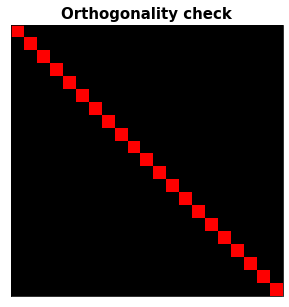

In [3]:
#* Find coefs that make up an orthogonal matrix
MFD = 6e-6 # randomised basis mode MFD
maxMG = 6
N = np.sum(range(maxMG + 1))
print(N)

coefs = mathutils.generate_random_base_coefs_using_SVD(basis_dim = N)

fig, axes = plt.subplots(nrows = 1, ncols = 1, gridspec_kw={'width_ratios': [1]})
fig.set_size_inches(6,6)

axes.plot(np.abs(coefs))
axes.set_title(f'coefs basis distribution')


#* Make the random spatial modes
wavelength = 856e-9
N_rs = 21 # Pixel count during raster scan
sim_pixel_size = 0.79333333e-6 # Pixel size during raster scan 
X_rs, Y_rs = np.meshgrid(sim_pixel_size*np.linspace(-N_rs/2,N_rs/2-1,N_rs),sim_pixel_size*np.linspace(-N_rs/2,N_rs/2-1,N_rs))

modes_object = modes.MODES(maxMG, X_rs, Y_rs, MFD, basis = 'LG', tilted = False, theta = 0, tilt_axis = 'x', xc = 0, yc = 0, z_offset = 0, wavelength = wavelength, meshgrid_rotation_angle = 0)
mode_fields = modes_object.MODES

randomised_modes = np.zeros((N, N_rs, N_rs), dtype = np.complex64)

for new_mode_idx in range(N):
    for mode_idx in range(N):
        randomised_modes[new_mode_idx] += coefs[new_mode_idx,mode_idx]*mode_fields[mode_idx]
        
#* Check orthogonality of the new basis
overlap_matrix = np.zeros((N,N), dtype = np.complex64)
for ii in range(N):
    for jj in range(N):
        
        overlap_matrix[ii,jj] = np.einsum('ij,ij->', randomised_modes[ii], np.conjugate(randomised_modes[jj]))


%matplotlib inline
fig, axes = plt.subplots(nrows = 1, ncols = 1, gridspec_kw={'width_ratios': [1]})
fig.set_size_inches(10,5)


ax_idx = 0
axes.imshow(plots.ComplexArrayToRgb(overlap_matrix))
axes.set_title(f'Orthogonality check')
axes.set_xticks([])
axes.set_yticks([])

# Plot all spatial modes in the random LG basis

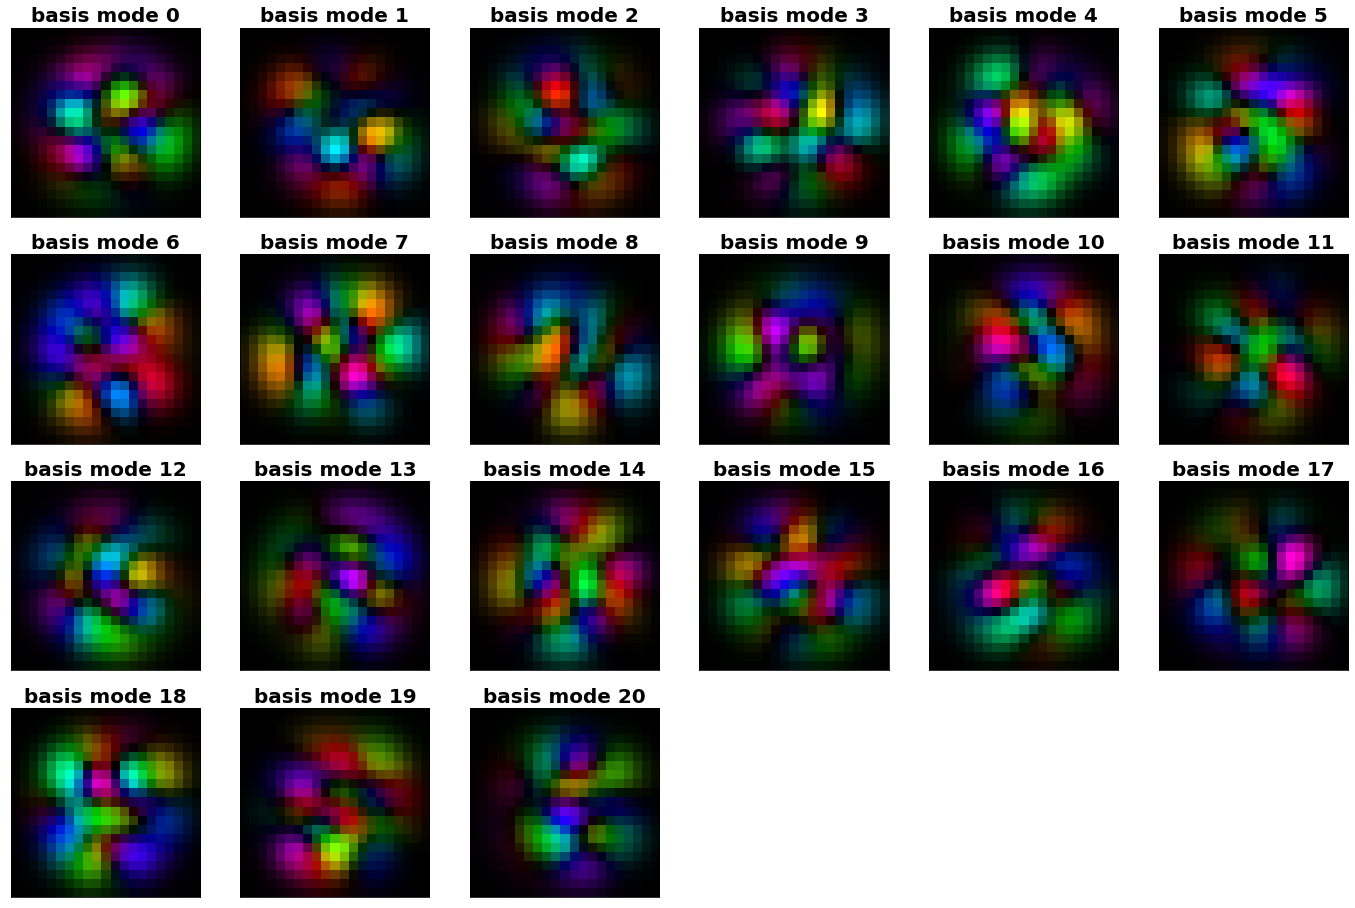

In [4]:
%matplotlib inline

number_of_columns = 6
if N <= number_of_columns:
    N_rows = 1
    N_cols = N
elif N > number_of_columns:
    N_rows = (N // number_of_columns) + 1
    N_cols = number_of_columns


widths = [1]*N_cols
heights = [1]*N_rows
gs_kw = dict(width_ratios=widths, height_ratios=heights)

plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'        
fig, axes = plt.subplots(nrows = N_rows, ncols = N_cols, gridspec_kw= gs_kw)
fig.set_size_inches(N_cols*4,N_rows*4)

if N_rows == 1:
    for c, ax in enumerate(axes):
        plot_idx = c 
        ax.imshow(plots.ComplexArrayToRgb(randomised_modes[plot_idx]))
        ax.set_title(f'basis mode {plot_idx}')
        ax.set_xticks([])
        ax.set_yticks([])
elif N_rows > 1:           
    for r, row in enumerate(axes):
        for c, ax in enumerate(row):
            plot_idx = c + number_of_columns*r
            if plot_idx < N:
                ax.imshow(plots.ComplexArrayToRgb(randomised_modes[plot_idx]))
                ax.set_title(f'basis mode {plot_idx}')
                ax.set_xticks([])
                ax.set_yticks([])
            else:
                ax.axis('off')

# VCSEL mode decomposition into randomised basis

[-0.1538539 -0.0389577j  -0.2591088 +0.03680719j -0.01239037-0.0705754j
 -0.1352832 -0.0956046j   0.19038878-0.24735734j -0.16259111-0.12300889j
  0.09397765+0.3298613j   0.05144963-0.01667816j  0.08093917-0.18488356j
  0.07799745+0.23636593j -0.06126904+0.12834871j -0.07787505-0.2599924j
 -0.22140457+0.0933141j   0.01847596+0.1649598j  -0.04447399-0.23026848j
  0.17496201+0.29320583j  0.02509852+0.11069857j  0.10723851+0.04930369j
 -0.12765294-0.05242184j  0.2630708 -0.04873547j -0.15119377+0.14297082j]


Text(0.5, 0.98, 'Initial states making the mixed state')

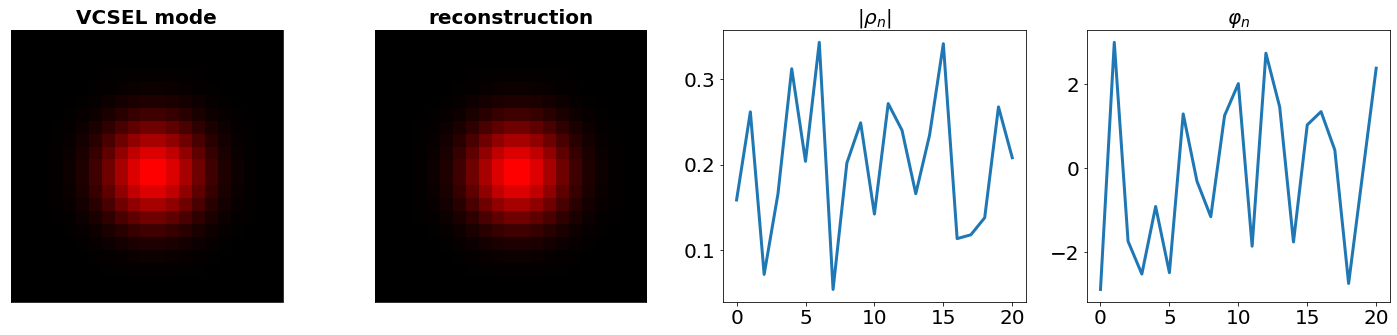

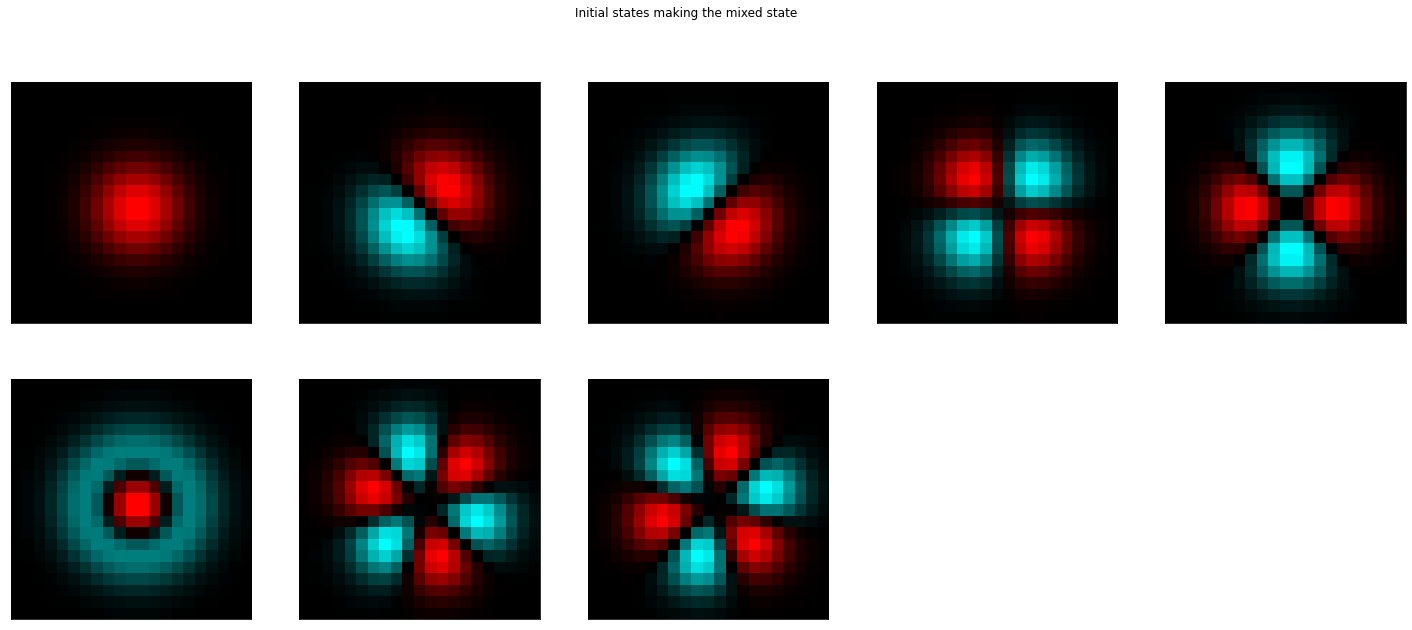

In [5]:
#* Make VCSEL modes as they might look like in the VCSEL laser output plane
N_VCSEL_modes = 8
VCSEL_MFD = 6e-6 # [m]
basis = 'LP'

#Let's assume the VCSEL modes are centered (centered experimentally)
xc = 0 
yc = 0

VCSEL_modes = np.zeros((N_VCSEL_modes,N_rs,N_rs), dtype = np.complex64)

# Define orientation, center and MFD for each VCSEL mode
for VCSEL_mode_idx in range(N_VCSEL_modes): 
    if VCSEL_mode_idx == 0:
        VCSEL_modes[VCSEL_mode_idx] = modes.mode_SLM_filter(X_rs, Y_rs, VCSEL_MFD, l = 0, m = 1, rotation_angle = np.pi/4, xc = xc, yc = yc, basis = basis).E
    elif VCSEL_mode_idx == 1:  
        VCSEL_modes[VCSEL_mode_idx] = modes.mode_SLM_filter(X_rs, Y_rs, VCSEL_MFD, l = 1, m = 1, rotation_angle = -np.pi/4, xc = xc, yc = yc, basis = basis).E
    elif VCSEL_mode_idx == 2:
        VCSEL_modes[VCSEL_mode_idx] = modes.mode_SLM_filter(X_rs, Y_rs, VCSEL_MFD, l = 1, m = 1, rotation_angle = np.pi/4, xc = xc, yc = yc, basis = basis).E
    elif VCSEL_mode_idx == 3:
        VCSEL_modes[VCSEL_mode_idx] = modes.mode_SLM_filter(X_rs, Y_rs, VCSEL_MFD, l = 2, m = 1, rotation_angle = np.pi/4, xc = xc, yc = yc, basis = basis).E
    elif VCSEL_mode_idx == 4:
        VCSEL_modes[VCSEL_mode_idx] = modes.mode_SLM_filter(X_rs, Y_rs, VCSEL_MFD, l = 2, m = 1, rotation_angle = 0, xc = xc, yc = yc, basis = basis).E
    elif VCSEL_mode_idx == 5:
        VCSEL_modes[VCSEL_mode_idx] = modes.mode_SLM_filter(X_rs, Y_rs, VCSEL_MFD, l = 0, m = 2, rotation_angle = np.pi/4, xc = xc, yc = yc, basis = basis).E
    elif VCSEL_mode_idx == 6:
        VCSEL_modes[VCSEL_mode_idx] = modes.mode_SLM_filter(X_rs, Y_rs, VCSEL_MFD, l = 3, m = 1, rotation_angle = -np.pi/4, xc = xc, yc = yc, basis = basis).E
    elif VCSEL_mode_idx == 7:
        VCSEL_modes[VCSEL_mode_idx] = modes.mode_SLM_filter(X_rs, Y_rs, VCSEL_MFD, l = 3, m = 1, rotation_angle = np.pi/4, xc = xc, yc = yc, basis = basis).E                



#* CALC OVERLAPS of the VCSEL modes with randomised basis (dim of basis is given by mode_count)
overlap_coefs = np.zeros((N_VCSEL_modes,N), dtype = np.complex64)

for VCSEL_mode_idx in range(N_VCSEL_modes):
    for random_mode_idx in range(N):
        overlap_coefs[VCSEL_mode_idx, random_mode_idx] = np.sum(VCSEL_modes[VCSEL_mode_idx]*np.conjugate(randomised_modes[random_mode_idx]))

#! VCSEL Mode coefficients in the randomised basis   
VCSEL_mode_coefs = overlap_coefs    


#* Reconstruct the VCSEL mode in the randomised basis
mode_idx = 0 # Selects which mode to reconstruct and plot to double check all is working as it should
reconstructed_mode = np.einsum("i,ikl->kl", VCSEL_mode_coefs[mode_idx], randomised_modes)
print(VCSEL_mode_coefs[mode_idx])

%matplotlib inline
fig, axes= plt.subplots(nrows = 1, ncols = 4, gridspec_kw={'width_ratios': [1,1,1,1]})
fig.set_size_inches(25,5)

mask_size = 1024
plot_range = 16
offset = 0.01

ax_idx = 0 
axes[ax_idx].imshow(plots.ComplexArrayToRgb(VCSEL_modes[mode_idx]))
axes[ax_idx].set_title('VCSEL mode')
axes[ax_idx].set_xticks([])
axes[ax_idx].set_yticks([])

ax_idx = 1 
axes[ax_idx].imshow(plots.ComplexArrayToRgb(reconstructed_mode))
axes[ax_idx].set_title('reconstruction')
axes[ax_idx].set_xticks([])
axes[ax_idx].set_yticks([])

ax_idx = 2
axes[ax_idx].plot(np.abs(VCSEL_mode_coefs[mode_idx,:]))
axes[ax_idx].set_title(r'$|\rho_n|$')

ax_idx = 3
axes[ax_idx].plot(np.angle(VCSEL_mode_coefs[mode_idx,:]))
axes[ax_idx].set_title(r'$\varphi_n$')





#* Plot all the modes in the mixed state 
N_rows = 2
N_cols = 5

widths = [1]*N_cols
heights = [1]*N_rows 
gs_kw = dict(width_ratios=widths, height_ratios=heights) 

plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.titleweight'] = 'bold'
fig, axes = plt.subplots(nrows = N_rows, ncols = N_cols, gridspec_kw= gs_kw) # One extra row for intensity profile
fig.set_size_inches(N_cols*5, N_rows*5)


running_idx = 0
for mode_idx in range(N_VCSEL_modes):
    if running_idx < N_cols:
        col_idx = mode_idx % N_cols
        axes[0, col_idx].imshow(plots.ComplexArrayToRgb(VCSEL_modes[running_idx]))
        axes[0, col_idx].set_xticks([])
        axes[0, col_idx].set_yticks([])
        running_idx += 1
    elif running_idx >= N_cols:
        col_idx = mode_idx % N_cols
        axes[1, col_idx].imshow(plots.ComplexArrayToRgb(VCSEL_modes[running_idx]))
        axes[1, col_idx].set_xticks([])
        axes[1, col_idx].set_yticks([])
        running_idx += 1
        
axes[1,3].axis('off')
axes[1,4].axis('off')          
    
fig.suptitle('Initial states making the mixed state')

# Generate Gell-Mann basis and find all eigenvalues and eigenvectors

In [6]:
gm = {} # The main Gell-Mann dictionary storing all the info

gm_basis_full = get_basis(N, order = "normal", exclude_identity_from_basis = False)

gm_eig_vals_vectors = get_gm_eig_vecs_and_vals(gm_basis_full)

#* Apply Frobenius norm squared to all Gell-Mann matrices 
for gm_idx in range(gm_basis_full.dim):
    gm_basis_full.basis[gm_idx] /= np.linalg.norm(gm_basis_full.basis[gm_idx])**2
        

gm.update({"density_matrix_construct":{}})

gm["density_matrix_construct"].update({"gm_basis_full": gm_basis_full})
gm["density_matrix_construct"].update({"eig_vals_vecs": gm_eig_vals_vectors})

# Determine unique measurement eigenvectors

In [7]:
gm_basis_no_identity = get_basis(N, order = "normal", exclude_identity_from_basis = True)

gm["density_matrix_construct"].update({"gm_basis_no_identity": gm_basis_no_identity})

unique_gm_eigvecs, unique_gm_eigvals =  get_unique_vecs_and_vals(gm["density_matrix_construct"]["gm_basis_no_identity"])
gm.update({"measurement": {}})
gm["measurement"].update({"eigenvectors": unique_gm_eigvecs})
gm["measurement"].update({"eigenvalues": unique_gm_eigvals})


# Define density matrix of generally mixed spatial state

0.0
The Input density matrix:
 [[ 2.51887229e-02+0.j          3.84309761e-02+0.01575721j
   4.65576220e-03-0.0103756j   2.45383826e-02-0.00943882j
  -1.96555826e-02-0.045474j    2.98074195e-02-0.01259122j
  -2.73094658e-02+0.04708929j -7.26598254e-03-0.00457036j
  -5.25016852e-03-0.03159826j -2.12084849e-02+0.03332722j
   4.42630946e-03+0.02213385j  2.21100849e-02-0.03696701j
   3.04286521e-02+0.02298215j -9.26905250e-03+0.02465993j
   1.58132270e-02-0.0336951j  -3.83412117e-02+0.03829474j
  -8.17406618e-03+0.01605363j -1.84198205e-02+0.0034078j
   2.16821365e-02-0.00309224j -3.85758439e-02-0.01774677j
   1.76919357e-02+0.02788678j]
 [ 3.84309761e-02-0.01575721j  6.84921453e-02+0.j
   6.12772430e-04-0.01874276j  3.15341334e-02-0.02975139j
  -5.84359393e-02-0.05708479j  3.76011792e-02-0.03785721j
  -1.22091709e-02+0.08892903j -1.39449279e-02-0.00242774j
  -2.77770970e-02-0.04492582j -1.15098626e-02+0.06411536j
   2.05995024e-02+0.03100114j  1.06085226e-02-0.07023268j
   6.08025037e-02+0

Text(0.5, 0.98, 'Initial states making the mixed state')

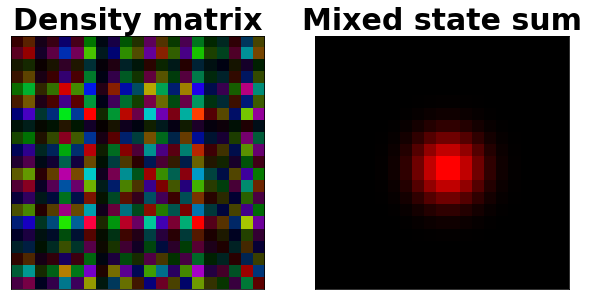

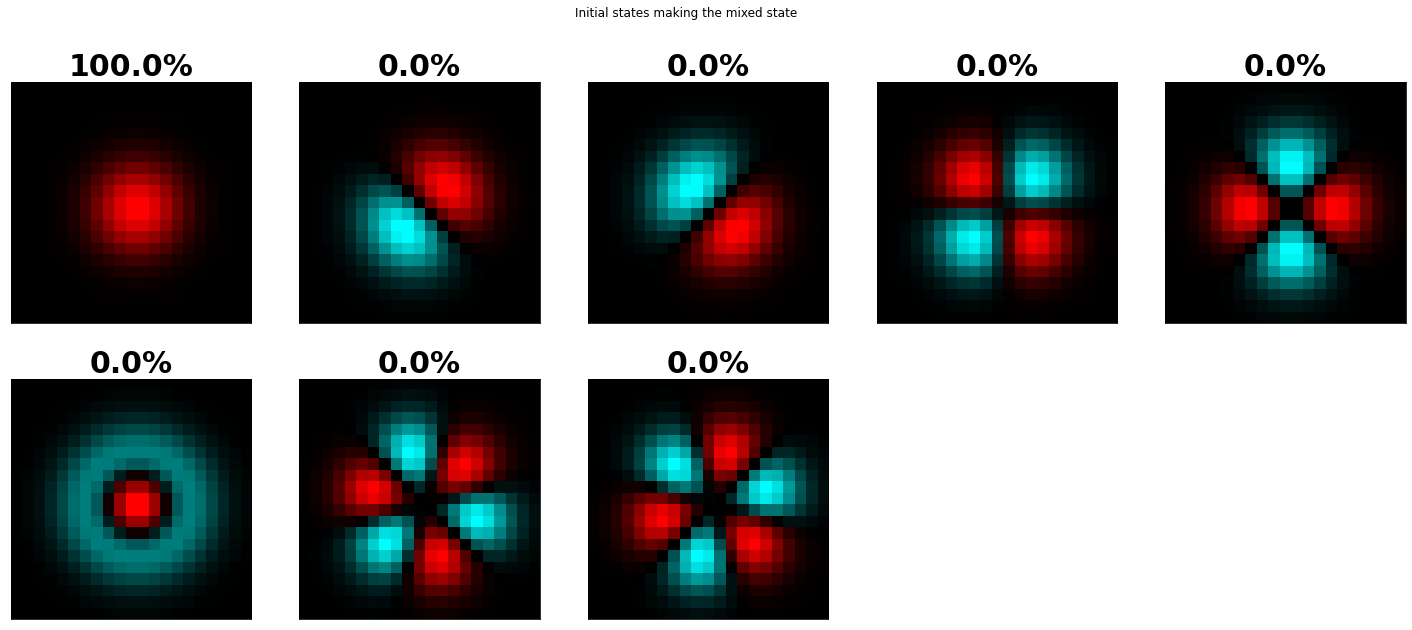

In [9]:
#* ================================= Define noise in the system ======================================================================

noise_offset = 0/100 # in % of the original signal
noise_sigma = 5/100 # in % of the original signal

#* ================================= Define a mixture ======================================================================
# p = np.array([0.155, 0.49, 0.072, 0.15, 0.09, 0.03, 0.003, 0.009], dtype = np.float32) # Real-experiment distribution

p = np.array([1.0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], dtype = np.float32) # Just one mode present (good for testing)

remaining_to_one = 1 - np.sum(p)
print(remaining_to_one)
max_idx = np.argmax(p)
p[max_idx] = p[max_idx] + remaining_to_one 



#* Make INPUT state density matrix
states = [] # list of orthonormal states
for state_idx in range(N_VCSEL_modes):
    _buffer = []
    for idx in range(N):
        _buffer.append([VCSEL_mode_coefs[state_idx][idx]])
    states.append(np.array(_buffer, dtype = np.complex128))    


input_density_matrix = np.zeros((N,N), dtype = np.complex128)

for state_idx in range(N_VCSEL_modes):
    input_density_matrix += p[state_idx]*(states[state_idx]@states[state_idx].conj().T)

print(f"The Input density matrix:\n {input_density_matrix}\n")

mixed_state_intensity = np.zeros((N_rs,N_rs), dtype = np.complex64)
for state_idx in range(N_VCSEL_modes):
    mixed_state_intensity += p[state_idx]*np.abs(VCSEL_modes[state_idx])**2
#* ------------------------------------------------------------------------------------------------------------------------------------

#! Figure 1
%matplotlib inline        
fig1, axes1 = plt.subplots(nrows = 1, ncols = 2, gridspec_kw={'width_ratios': [1,1]})
fig1.set_size_inches(10,5)



ax_idx = 0
axes1[ax_idx].imshow(plots.ComplexArrayToRgb(input_density_matrix))
axes1[ax_idx].set_title(f'Density matrix')
axes1[ax_idx].set_xticks([])
axes1[ax_idx].set_yticks([])


ax_idx = 1
axes1[ax_idx].imshow(plots.ComplexArrayToRgb(mixed_state_intensity))
axes1[ax_idx].set_title(f'Mixed state sum')
axes1[ax_idx].set_xticks([])
axes1[ax_idx].set_yticks([])


#* Plot all the modes in the mixed state 
N_rows = 2
N_cols = 5


widths = [1]*N_cols
heights = [1]*N_rows 
gs_kw = dict(width_ratios=widths, height_ratios=heights) 

plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.titleweight'] = 'bold'
fig, axes = plt.subplots(nrows = N_rows, ncols = N_cols, gridspec_kw= gs_kw) # One extra row for intensity profile
fig.set_size_inches(N_cols*5, N_rows*5)


running_idx = 0
for mode_idx in range(N_VCSEL_modes):
    if running_idx < N_cols:
        col_idx = mode_idx % N_cols
        axes[0, col_idx].imshow(plots.ComplexArrayToRgb(VCSEL_modes[running_idx]))
        axes[0, col_idx].set_title(f'{p[running_idx]*100:0.1f}%')
        axes[0, col_idx].set_xticks([])
        axes[0, col_idx].set_yticks([])
        running_idx += 1
    elif running_idx >= N_cols:
        col_idx = mode_idx % N_cols
        axes[1, col_idx].imshow(plots.ComplexArrayToRgb(VCSEL_modes[running_idx]))
        axes[1, col_idx].set_title(f'{p[running_idx]*100:0.1f}%')
        axes[1, col_idx].set_xticks([])
        axes[1, col_idx].set_yticks([])
        running_idx += 1
        
axes[1,3].axis('off')
axes[1,4].axis('off')          
    
fig.suptitle('Initial states making the mixed state')

# Double check that the input matrix gives the correct eigenstates and eigenvalues (probabilities)

In [12]:
#* ================================= Predicted eigenstates (calced straight from constructed density matrix) =========================================================================
debugging = False

initial_eigen_states = []

T, Z = schur(input_density_matrix)

for idx in range(N):
    initial_eigen_states.append({"eigenvalue":eigvals(T)[idx].real, "eigenvector": Z[:,idx]})

if debugging:
    print(f"Initial density matrix eigenvalues/eigenvectors:") 
    for idx in range(N):
        print(f"{initial_eigen_states[idx]}")
#* ------------------------------------------------------------------------------------------------------------------------------------

# Perform projective measurements using different noise data (equivalent to repeating the real measurement)

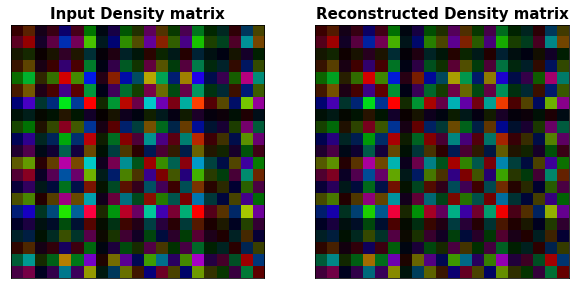

In [13]:
N_iterations = 1 # How many times to perform the projective measurement with different noise (Repeating x times to determine the expected measurement error in terms of individual mode probabilities)

probability_buffer = np.zeros((N_iterations, N_VCSEL_modes), dtype = np.float32)

for iteration_idx in range(N_iterations):

    debugging = False
    sort_states_by_probability = False

    #* ================================= Perform projective measurements on inital density matrix ========================================================
    eigenstates_intensities  = np.zeros((2*N**2 - N), dtype = np.float64)
    eigenstates_noise = np.random.normal(loc = noise_offset, scale = noise_sigma, size = 2*N**2 - N)

    if debugging:
        print(eigenstates_noise)

    for eig_idx in range(2*N**2 - N):
        projection_eigenstate = np.array([gm["measurement"]["eigenvectors"][eig_idx]], dtype = np.complex128).T
        projection_observable = projection_eigenstate@projection_eigenstate.conj().T
        
        #! Simulated measured intensities with noise and noise offset
        eigenstates_intensities[eig_idx] = np.trace(input_density_matrix@projection_observable).real + \
                                            + (np.trace(input_density_matrix@projection_observable).real)*eigenstates_noise[eig_idx] + \
                                            + (np.trace(input_density_matrix@projection_observable).real)*noise_offset

    gm["measurement"].update({"eigenstates_intensities": eigenstates_intensities})

    if debugging:
        print("")
        print(f'The intensity measurements in eigenstates are:\n{gm["measurement"]["eigenstates_intensities"]}')
    #* ------------------------------------------------------------------------------------------------------------------------------------





    for gm_idx in range(gm_basis_full.dim): # Going over all the Gell-Mann matrices
        for idx in range(N): 
            eigval = gm["density_matrix_construct"]["eig_vals_vecs"][gm_idx][idx]["eigenvalue"]
            eigvec = gm["density_matrix_construct"]["eig_vals_vecs"][gm_idx][idx]["eigenvector"]
            if eigval != 0:
                for eig_idx in range(2*N**2 - N):
                    if np.array_equal(eigvec, gm["measurement"]["eigenvectors"][eig_idx]):
                        gm["density_matrix_construct"]["eig_vals_vecs"][gm_idx][idx].update({"intensity": gm["measurement"]["eigenstates_intensities"][eig_idx]})
            else:
                gm["density_matrix_construct"]["eig_vals_vecs"][gm_idx][idx].update({"intensity": 0}) 
            
            
            


    debugging = False

    gm_idx = 0

    if debugging:
        print('Gell-Mann matrix:')
        print(f'{gm["density_matrix_construct"]["gm_basis_full"].basis[gm_idx]}\n')

        for idx in range(N):
            print(gm["density_matrix_construct"]["eig_vals_vecs"][gm_idx][idx])

        
    S = 0   
    for idx in range(N):
        S += gm["density_matrix_construct"]["eig_vals_vecs"][gm_idx][idx]["eigenvalue"]*gm["density_matrix_construct"]["eig_vals_vecs"][gm_idx][idx]["intensity"]

    if debugging:
        print("")
        print(f"Stokes parameter (calced from measurement): {S}")





    #* Reconstruct Stokes vector
    stokes_vector = np.zeros((N**2), dtype = np.float32)

    for gm_idx in range(N**2): 
        for eig_idx in range(N):
            eigval = gm["density_matrix_construct"]["eig_vals_vecs"][gm_idx][eig_idx]["eigenvalue"]
            I = gm["density_matrix_construct"]["eig_vals_vecs"][gm_idx][eig_idx]["intensity"]
            
            stokes_vector[gm_idx] += eigval*I

    gm["density_matrix_construct"].update({"stokes_vector": stokes_vector})

    gm["density_matrix_construct"]["stokes_vector"] /= S # Normalise the Stokes vector

    if debugging:
        print(f'The measured Stokes vector is:\n{gm["density_matrix_construct"]["stokes_vector"]}\n')




    #* Reconstruct the density matrix
    reconstructed_density_matrix = np.zeros((N,N), dtype = np.complex128)
    reconstructed_density_matrix_PD = np.zeros((N,N), dtype = np.complex128) # Positive semi-definite form 

    for gm_idx in range(N**2):
        S = gm["density_matrix_construct"]["stokes_vector"][gm_idx]
        GM_matrix = gm["density_matrix_construct"]["gm_basis_full"].basis[gm_idx]     
        reconstructed_density_matrix += S*GM_matrix

    reconstructed_density_matrix_PD = mathutils.nearestPD(reconstructed_density_matrix)
    
    #! Figure 1
    %matplotlib inline        

    #* Set font style. Check the default matplotlibrc file to see all the available parameters
    plt.rcParams['axes.labelsize'] = 20
    plt.rcParams['axes.labelweight'] = 'bold'
    plt.rcParams['axes.titlesize'] = 15
    plt.rcParams['axes.titleweight'] = 'bold'

    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.labelsize'] = 20

    plt.rcParams['lines.linewidth'] = 3
    plt.rcParams['lines.markersize'] = 10

    plt.rcParams['legend.fontsize'] = 15


    fig, axes = plt.subplots(nrows = 1, ncols = 2, gridspec_kw={'width_ratios': [1,1]})
    fig.set_size_inches(10,5)

    ax_idx = 0
    axes[ax_idx].imshow(plots.ComplexArrayToRgb(input_density_matrix))
    axes[ax_idx].set_title(f'Input Density matrix')
    axes[ax_idx].set_xticks([])
    axes[ax_idx].set_yticks([])

    ax_idx = 1
    axes[ax_idx].imshow(plots.ComplexArrayToRgb(reconstructed_density_matrix_PD))
    axes[ax_idx].set_title(f'Reconstructed Density matrix')
    axes[ax_idx].set_xticks([])
    axes[ax_idx].set_yticks([])




    #* Find the eigenstates and eigenvectors
    reconstructed_eigen_states = []

    T, Z = schur(reconstructed_density_matrix)

    for idx in range(N):
        reconstructed_eigen_states.append({"eigenvalue":eigvals(T)[idx].real, "eigenvector": Z[:,idx]})

    if debugging:    
        print(f"INPUT probabilities of random orthogonal states in the mixture are:\n{p}\n")


        print("")
        print(f"RECONSTRUCTED density matrix eigenvalues/eigenvectors:") 
        for idx in range(N):
            print(f"{reconstructed_eigen_states[idx]}")

    #* ============================= Find eigenvalues and eigenvectors ===============================================================

    reconstructed_eigen_states_PD_eigenvectors = np.zeros((N, N), dtype = np.complex128) # We get N vectors of size N for each lambda_idx
    reconstructed_eigen_states_PD_eigenvalues = np.zeros((N), dtype = np.float64) # We get N eigenvalues corresponding to N eigenvectors for each lambda_idx

    T_PD, Z_PD = schur(reconstructed_density_matrix_PD)
        
    for idx in range(N):
        reconstructed_eigen_states_PD_eigenvectors[:, idx] =  Z_PD[:, idx]
        reconstructed_eigen_states_PD_eigenvalues[idx] =  np.abs(eigvals(T_PD)[idx].real) 


    #* ============================= Re-normalise so that the eigenvalues add up to 100 % ===============================================================  
    power_norm = np.sum(reconstructed_eigen_states_PD_eigenvalues)    
    reconstructed_eigen_states_PD_eigenvalues /= power_norm


    #* ============================= Sort eigestates in descending order of their probability in the mixture =============================================================== 
    reconstructed_eigen_states_PD_eigenvectors_sorted = np.zeros((N, N), dtype = np.complex128) # We get N vectors of size N for each lambda_idx
    reconstructed_eigen_states_PD_eigenvalues_sorted = np.zeros((N), dtype = np.float64) # We get N eigenvalues corresponding to N eigenvectors for each lambda_idx

    if sort_states_by_probability:
        
        eigenvalues_unsorted = reconstructed_eigen_states_PD_eigenvalues.copy()
        sorting_indices = np.argsort(eigenvalues_unsorted)
        sorting_indices = sorting_indices[::-1]  # making sure all is sorted in descending order 

            
        for idx in range(N):
            reconstructed_eigen_states_PD_eigenvectors_sorted[:, idx] = reconstructed_eigen_states_PD_eigenvectors[:, sorting_indices[idx]].copy()
            reconstructed_eigen_states_PD_eigenvalues_sorted[idx] =  reconstructed_eigen_states_PD_eigenvalues[sorting_indices[idx]].copy()
    else:
        for idx in range(N):
            reconstructed_eigen_states_PD_eigenvectors_sorted[:, idx] = reconstructed_eigen_states_PD_eigenvectors[:, idx].copy()
            reconstructed_eigen_states_PD_eigenvalues_sorted[idx] =  reconstructed_eigen_states_PD_eigenvalues[idx].copy()        
        
    overlap_input_vs_output_states = np.zeros(N_VCSEL_modes, dtype = np.float32)
        
    for idx in range(N_VCSEL_modes):    
        norm_input_state = np.linalg.norm(VCSEL_mode_coefs[idx,:])
        norm_reconstructed_state = np.linalg.norm(reconstructed_eigen_states_PD_eigenvectors_sorted[:, idx])
        overlap_norm =  norm_input_state * norm_reconstructed_state

        overlap_input_vs_output_states[idx] = np.abs(np.sum(reconstructed_eigen_states_PD_eigenvectors_sorted[:, idx]*np.conj(VCSEL_mode_coefs[idx,:])))**2/overlap_norm

    #* ======================================= Reconstruct spatial states ================================================================================================
    reconstructed_spatial_eigenstates = np.zeros((N, N_rs, N_rs), dtype = np.complex64)

    for state_idx in range(N):
        for idx in range(N):
            
            # reconstructed_spatial_eigenstates[state_idx] += reconstructed_eigen_states[state_idx]["eigenvector"][idx]*randomised_modes[idx]
            reconstructed_spatial_eigenstates[state_idx] += reconstructed_eigen_states_PD_eigenvectors_sorted[idx, state_idx]*randomised_modes[idx]
            # reconstructed_spatial_eigenstates[state_idx] += VCSEL_mode_coefs[state_idx, idx]*randomised_modes[idx]


    #* Sort the input states
    if sort_states_by_probability:
        VCSEL_modes_sorted = VCSEL_modes.copy()
        p_sorted = p.copy()

        VCSEL_states_sorting_indices = np.argsort(p)
        VCSEL_states_sorting_indices = VCSEL_states_sorting_indices[::-1]  # making sure all is sorted in descending order

        for state_idx in range(N_VCSEL_modes):
            VCSEL_modes_sorted[state_idx] = VCSEL_modes[VCSEL_states_sorting_indices[state_idx]]
            p_sorted[state_idx] = p[VCSEL_states_sorting_indices[state_idx]] 
    else:
        VCSEL_modes_sorted = VCSEL_modes.copy()
        p_sorted = p.copy()
        
        probability_buffer[iteration_idx,:] = reconstructed_eigen_states_PD_eigenvalues_sorted[0:N_VCSEL_modes]       

# Plotting

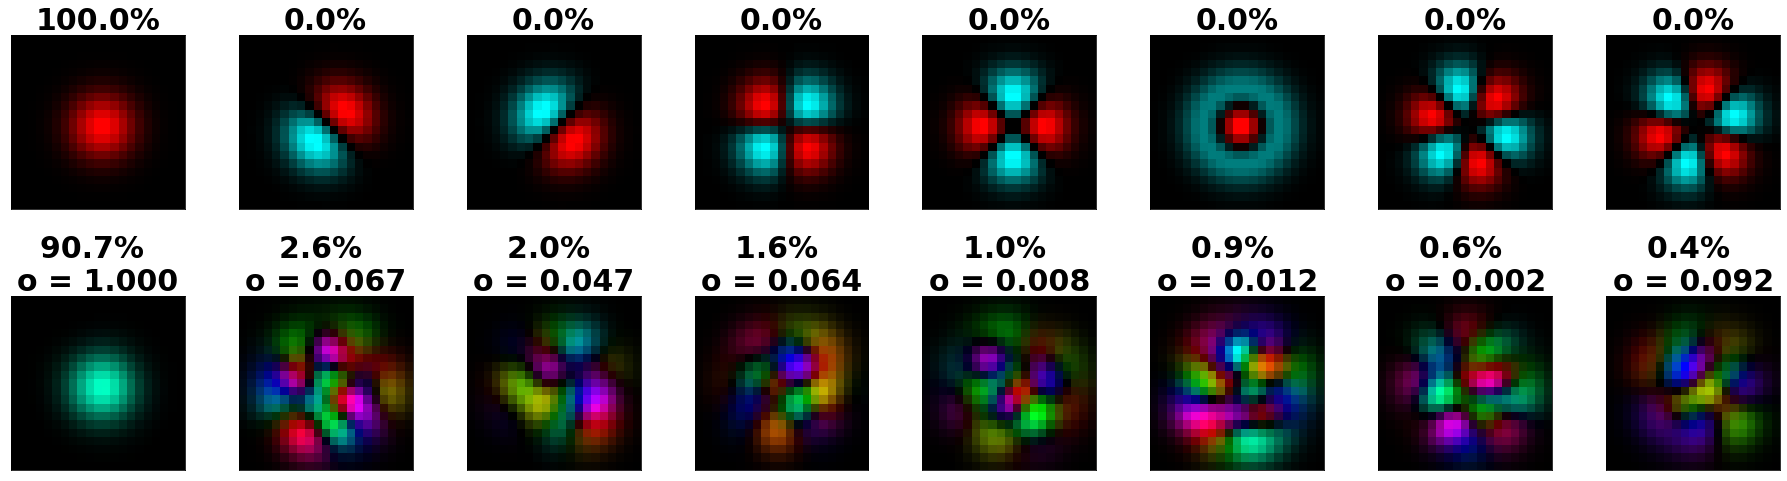

In [14]:
N_rows = 2
N_cols = 8


widths = [1]*N_cols
heights = [1]*N_rows 
gs_kw = dict(width_ratios=widths, height_ratios=heights)



plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.titleweight'] = 'bold'
fig, axes = plt.subplots(nrows = N_rows, ncols = N_cols, gridspec_kw= gs_kw) # One extra row for intensity profile
fig.set_size_inches(N_cols*4, N_rows*4)
plt.subplots_adjust(wspace = 0.2, hspace = 0.5) 


running_idx = 0
for mode_idx in range(N_VCSEL_modes):
    if running_idx < N_cols:
        col_idx = running_idx % N_cols
        axes[0, col_idx].imshow(plots.ComplexArrayToRgb(VCSEL_modes_sorted[running_idx]))
        axes[0, col_idx].set_title(f'{p_sorted[running_idx]*100:0.1f}%')
        axes[0, col_idx].set_xticks([])
        axes[0, col_idx].set_yticks([])
        
        axes[1, col_idx].imshow(plots.ComplexArrayToRgb(reconstructed_spatial_eigenstates[running_idx]))
        axes[1, col_idx].set_title(f'{reconstructed_eigen_states_PD_eigenvalues_sorted[running_idx]*100:0.1f}% \no = {overlap_input_vs_output_states[running_idx]:0.3f}')
        axes[1, col_idx].set_xticks([])
        axes[1, col_idx].set_yticks([])
        
        running_idx += 1


save_image = False
if save_image:
    plt.savefig(os.path.join(os.getcwd(),"si_material_noise","stokes_spectrum_5_percent_noise_modes.svg"))         